In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import BinaryCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, recall_score, \
                            precision_score, ConfusionMatrixDisplay

from typing import List

In [34]:
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

df_concat = df1._append(df2, ignore_index=True)
df_concat = df_concat.iloc[:, 2:]
df_concat.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [35]:
df_concat.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.091129
std,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.465650
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [36]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    1298

In [37]:
df_concat.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

In [38]:
df_concat.fillna({'Arrival Delay in Minutes': df_concat['Arrival Delay in Minutes'].mean()}, inplace=True)

In [39]:
def replaceCategorial(df: pd.DataFrame, columns: List[str], mapping: dict) -> None:
  for column in columns:
    df[column] = df[column].map(mapping)

In [40]:
replaceCategorial(df_concat, ['Gender'], {'Male': 0, 'Female': 1})
replaceCategorial(df_concat, ['Customer Type'], {'disloyal Customer': 0, 'Loyal Customer': 1})
replaceCategorial(df_concat, ['Type of Travel'], {'Personal Travel': 0, 'Business travel': 1})
replaceCategorial(df_concat, ['Class'], {'Eco': 0, 'Eco Plus': 1, 'Business': 2})
replaceCategorial(df_concat, ['satisfaction'], {'neutral or dissatisfied': 0, 'satisfied': 1})

df_concat.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,1,13,0,1,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,0,0,25,1,2,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,1,26,1,2,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,1,1,25,1,2,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,0,1,61,1,2,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [85]:
X = df_concat.drop('satisfaction', axis=1)
y = df_concat['satisfaction']

# Normalization
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42327)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42239435)

print(
  f"Train: {X_train.shape}, {y_train.shape}\n"
  f"Val: {X_val.shape}, {y_val.shape}\n"
  f"Test: {X_test.shape}, {y_test.shape}"
)

Train: (83123, 22), (83123,)
Val: (20781, 22), (20781,)
Test: (25976, 22), (25976,)


In [95]:
keras.clear_session()

model = Sequential([
  Dense(X_train.shape[1], activation='sigmoid'),
  BatchNormalization(),
  Dense(32, activation='relu'),
  Dropout(.2),
  BatchNormalization(),
  Dense(16, activation='tanh'),
  Dropout(.4),
  BatchNormalization(),
  Dense(32, activation='relu'),
  BatchNormalization(),
  Dense(16, activation='tanh'),
  Dropout(.2),
  BatchNormalization(),
  Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [96]:
callback = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

model.compile(optimizer=Adam(learning_rate=0.0002), loss=BinaryCrossentropy(), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=384, validation_data=(X_val, y_val), epochs=500, callbacks=[callback])

Epoch 1/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6446 - loss: 0.6484 - val_accuracy: 0.5159 - val_loss: 0.6420
Epoch 2/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8037 - loss: 0.4461 - val_accuracy: 0.8561 - val_loss: 0.3496
Epoch 3/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8431 - loss: 0.3887 - val_accuracy: 0.8804 - val_loss: 0.3066
Epoch 4/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8619 - loss: 0.3532 - val_accuracy: 0.8891 - val_loss: 0.2913
Epoch 5/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8712 - loss: 0.3323 - val_accuracy: 0.8970 - val_loss: 0.2773
Epoch 6/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8794 - loss: 0.3170 - val_accuracy: 0.9018 - val_loss: 0.2624
Epoch 7/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8849 - loss: 0.3032 - val_accuracy: 0.9076 - val_loss: 0.2510
Epoch 8/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8932 - loss: 0.2872 - val_accu

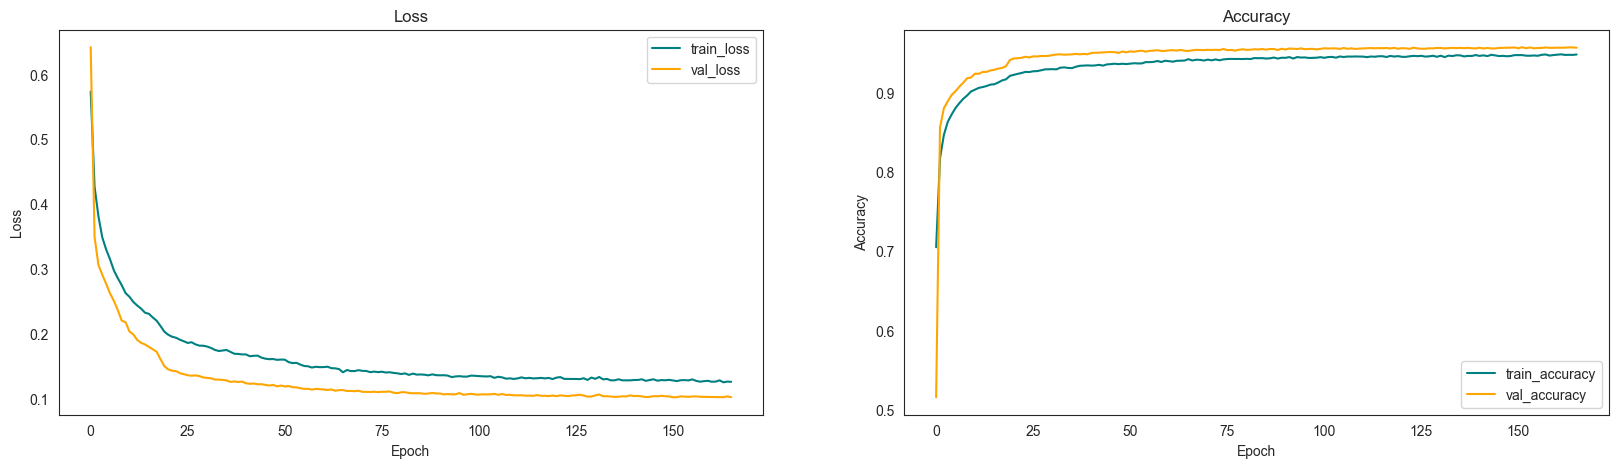

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(history.history['loss'], color = 'teal', label = 'train_loss')
ax[0].plot(history.history['val_loss'], color = 'orange', label = 'val_loss')
ax[0].title.set_text('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')

ax[1].plot(history.history['accuracy'], color = 'teal', label = 'train_accuracy')
ax[1].plot(history.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
ax[1].title.set_text('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='lower right')

plt.show()

In [99]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.9586 - loss: 0.1006
Loss: 0.10286619514226913, Accuracy: 0.9576147198677063


In [109]:
score_dict = {}
pred = (model.predict((X_test, y_test)) > 0.5).astype(int)

print(classification_report(pred, y_test))

score_dict['model'] = {
  'accuracy': accuracy_score(y_test.values, pred),
  'precision': precision_score(y_test.values, pred),
  'recall': recall_score(y_test.values, pred),
  'f1_score': f1_score(y_test.values, pred),
  'roc_auc': roc_auc_score(y_test.values, pred),
}

for key, value in score_dict['model'].items():
  print(f"{key:<10}: {value}")

812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     15044
           1       0.94      0.96      0.95     10932

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976

accuracy  : 0.9576147212811826
precision : 0.9623124771313575
recall    : 0.9385315371576411
f1_score  : 0.9502732487240866
roc_auc   : 0.9553157448773241


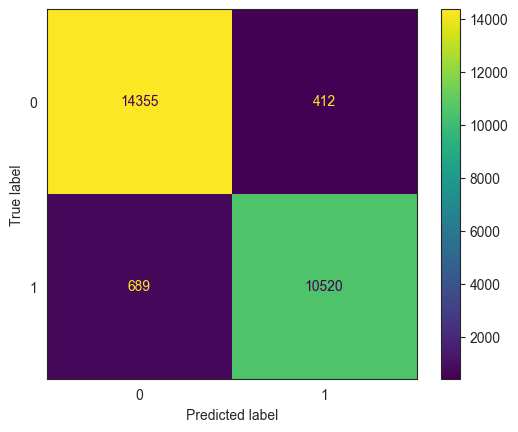

In [101]:
sns.set_style('white')

ConfusionMatrixDisplay.from_predictions(y_test.values, pred)